In [1]:
import ipywidgets as widgets
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import time


from matplotlib import rc 
import matplotlib.animation as animation
from collections import deque
from IPython.display import HTML

In [2]:
from functions_v3_1 import arrival_cost_values, get_arrival_obj, MS_functions_MHE, generate_meas, cnlls_solver, MHE
# works definitely for this with functions_v3_1-Copy1.py

from animate import get_cart_x, get_cart_y, get_ball_x, get_ball_y, animate_pendulum, animatecomparison_pendulum

# Model Dynamics

In [3]:
# our parameters !
m = 1
M = 5
l = 1 # attention! l must be also changed in the animate.py file!
g = 9.81

In [4]:
# defining the rhs of the ODE system

# state variables
x1 = MX.sym('x1') #r
x2 = MX.sym('x2') #rdot
x3 = MX.sym('x3') #theta
x4 = MX.sym('x4') #thetadot
x = vertcat(x1,x2,x3,x4)

# parameter
p = MX.sym('p')

u=0

# rhs
rhs_exp = vertcat(x2,
             (-m*g*cos(x3)*sin(x3)-m*l*x4*x4*sin(x3)+u)/(M+m*sin(x3)*sin(x3)),
             x4,
             -g/l*sin(x3)+ cos(x3)/l*((-m*g*cos(x3)*sin(x3)-m*l*x4*x4*sin(x3)+u)/(M+m*sin(x3)*sin(x3)))-p/m*x4)

rhs = Function('rhs',[x,p],[rhs_exp])

# Simulation

In [5]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true = [0.5]

eps = 0.8
s0 = [0, 0, pi-eps, 0]
x0 = s0 ## initial conditions from paper
Res1 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res1 = vertcat(Res1,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
print(Res1.shape)

(404, 1)


# Simulation with p=0 as comparison

In [6]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true2 = [0.]


s0 = x0 ## initial conditions from paper
Res2 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true2)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res2 = vertcat(Res2,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
#print(Res2.shape)

In [7]:
#animate_pendulum('../plots/pendulum/simulation.gif', Res1)

MovieWriter Pillow unavailable; using Pillow instead.


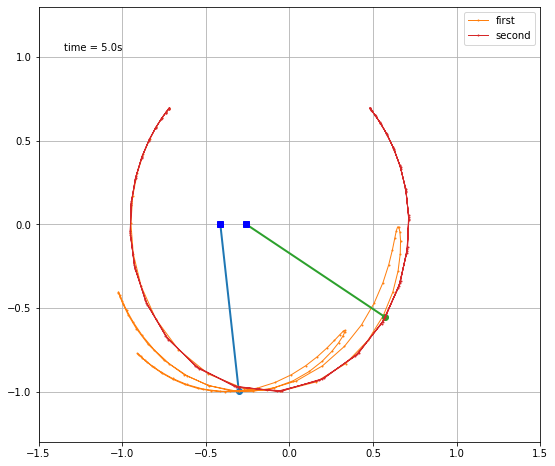

In [8]:
animatecomparison_pendulum('../plots/pendulum/simulation_comp.gif', Res1,Res2)

In [9]:
sigma = [0.01,0.01,0.1,0.01]
sigma2 = [0.00001,0.00002,0.0002,0.0001]
M = L*N
meas = generate_meas(x, p, rhs_exp, L*T, sigma, p_true, M, x0)

In [10]:
# we need to reshape for visualization
meas1 = []
for i in range(M+1):
    meas1 = vertcat(meas1,meas[:,i])
print(meas1.shape)

(404, 1)


In [11]:
#animate_pendulum('../plots/pendulum/measurements.gif', meas1)

# Open-loop PE for the first MHE horizon
 here the first 10 shooting intervals (->11 measurements)

In [12]:
#debugging arrival_cost_values
n = x.shape[0]
m = p.shape[0]

x_opt = x0
p_opt = [0]
last_y = meas[:,0]
last_P = np.diag(np.ones(n+m))
last_V = np.diag(sigma)
last_W = np.diag(np.ones(n+m))

P_Lplus1, xandpbar = arrival_cost_values(x,p,rhs_exp,T,N,x_opt, p_opt, last_y, last_P,last_V, last_W)
arr = get_arrival_obj(n,m,P_Lplus1, xandpbar)

In [13]:
start = 10
# arr0 = Function('arr0',[vertcat(x,p)],[0])
FF1, FF2 = MS_functions_MHE(T, N, x, p, rhs_exp, meas[:,start:start+(N+1)], sigma,sigma2, arr)

In [14]:
p0= [0]
w0 = vertcat(meas1[start:start+x.shape[0]*(N+1)],np.zeros(x.shape[0]*N))
w0 = vertcat(w0,p0)
w = MX.sym('w',w0.shape[0])
#k=0
y = meas[:,N+start]
#print(y.shape)
F1 = Function('F1',[w],[FF1(w,y)])
F2 = Function('F2',[w],[FF2(w,y)])

In [15]:
print(arr)
print(P_Lplus1.shape)
print(xandpbar.shape)

arr:(i0[5])->(o0[5]) MXFunction
(5, 5)
(5, 1)


In [16]:
w_opt = cnlls_solver(F1, F2, w0, itmax=100, tol=1e-7, ggn = False, show_iteration = False)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        14
       nlp_g  |        0 (       0)        0 (       0)        14
  nlp_grad_f  |  10.00ms (769.23us)  10.01ms (769.77us)        13
  nlp_hess_l  | 634.00ms ( 57.64ms) 633.95ms ( 57.63ms)        11
   nlp_jac_g  | 250.00ms ( 19.23ms) 251.16ms ( 19.32ms)        13
       total  | 910.00ms (910.00ms) 910.76ms (910.76ms)         1


In [17]:
leng = w_opt.shape[0]
pp_opt = w_opt[leng-p.shape[0]:]
vv_opt = w_opt[(N+1)*x.shape[0]:leng-p.shape[0]]
ss_opt = w_opt[0:(N+1)*x.shape[0]]
print(pp_opt)
print(ss_opt.shape)

[0.28495225]
(44,)


MovieWriter Pillow unavailable; using Pillow instead.


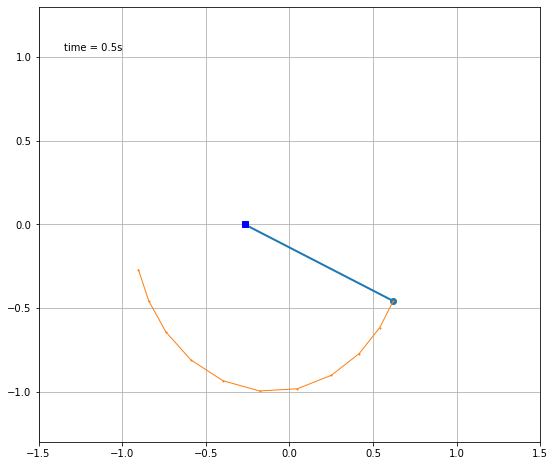

In [18]:
animate_pendulum('../plots/pendulum/ipopt_short.gif', ss_opt)

# Open-loop PE for all measurements

In [19]:
FF1, FF2 = MS_functions_MHE(L*T, L*N, x, p, rhs_exp, meas, sigma,sigma2, arr)

In [20]:
p0= [0]
w0 = vertcat(meas1,np.zeros(N*L*x.shape[0]))
w0 = vertcat(w0,p0)
ww = MX.sym('ww',w0.shape[0])
#k=0
y = meas[:,M]
#print(y.shape)
F1 = Function('F1',[ww],[FF1(ww,y)])
F2 = Function('F2',[ww],[FF2(ww,y)])

In [21]:
w_opt = cnlls_solver(F1, F2, w0, itmax=10 , tol=1e-7, ggn = False, show_iteration = False)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (200.00us)   1.04ms (209.00us)         5
       nlp_g  |   8.00ms (  1.60ms)   7.49ms (  1.50ms)         5
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |   1.65 s (412.00ms)   1.65 s (412.29ms)         4
   nlp_jac_g  | 806.00ms (134.33ms) 805.76ms (134.29ms)         6
       total  |   2.48 s (  2.48 s)   2.48 s (  2.48 s)         1


In [22]:
len_w = w_opt.shape[0]
p_opt = w_opt[len_w-p.shape[0]:]
v_opt = w_opt[(L*N+1)*x.shape[0]:len_w-p.shape[0]]
s_opt = w_opt[0:(L*N+1)*x.shape[0]]

print(p_opt)
print(v_opt.shape)
print(s_opt.shape)

[0.50015883]
(400,)
(404,)


MovieWriter Pillow unavailable; using Pillow instead.


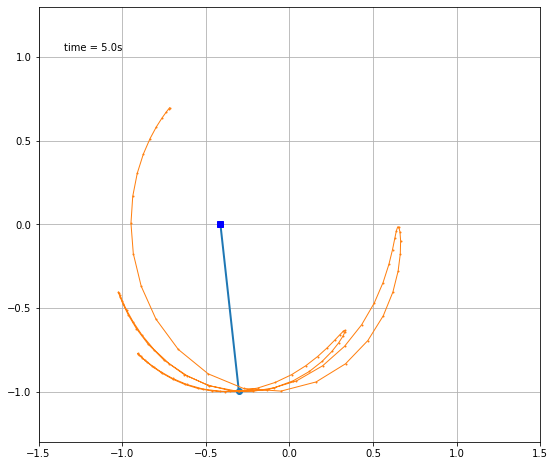

In [23]:
animate_pendulum('../plots/pendulum/ipopt.gif', s_opt)

# MHE

In [24]:
T = 2* 0.5
N = 2* 10
P = np.diag(np.ones(n+m))
p0 = [0.]
r0 = vertcat(meas1[:(N+1)*x.shape[0]],np.zeros(N*x.shape[0]))
r0 = vertcat(r0,p0)
print(r0.shape)
length_simulation = 30
#sigma = 0.01 (defined above)
W = np.diag(np.ones(n+m))

(165, 1)


In [25]:
xx, pp = MHE(P, r0, T, N, length_simulation, x, p, rhs_exp, meas, sigma,sigma2, W, ggn = False)

starting (time horizon) loop no.  1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         2
       nlp_g  |        0 (       0)        0 (       0)         2
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  |  94.00ms ( 94.00ms)  93.65ms ( 93.65ms)         1
   nlp_jac_g  |  94.00ms ( 31.33ms)  94.15ms ( 31.38ms)         3
       total  | 188.00ms (188.00ms) 187.80ms (187.80ms)         1
needed time for loop 0 0.27390209999999726
starting (time horizon) loop no.  2
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         2
       nlp_g  |        0 (       0)        0 (       0)         2
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  |  81.00ms ( 81.00ms)  81.10ms ( 81.10ms)         1
   nlp_jac_g  |  79.00ms ( 26.33ms)  78.63ms ( 26.21ms)         3
       total  | 173.00ms (1

In [26]:
#animate_pendulum('../plots/pendulum/mhe.gif',xx)

MovieWriter Pillow unavailable; using Pillow instead.


IndexError: index 51 is out of bounds for axis 0 with size 51

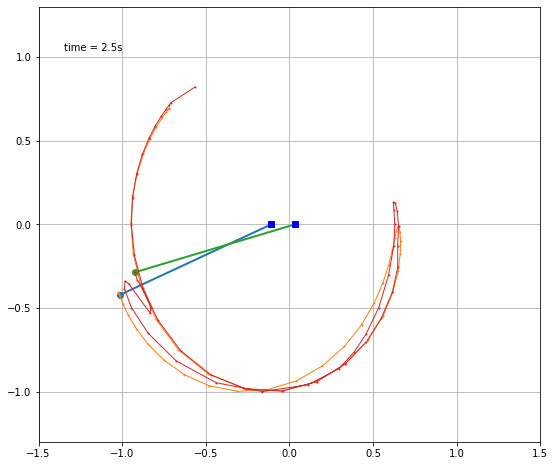

In [27]:
animatecomparison_pendulum('../plots/pendulum/mhe_comp.gif', Res1,xx)

In [ ]:
plt.figure(figsize=(10,8))
plt.title("Comparison of the simulations:")
plt.xlim(-1.,1.)
plt.ylim(-1.3,1.3)

ss = Res1 # true
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

ss = Res2 # true comp
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,linestyle = 'dotted', label = "true comp")   

ss = meas1 # meas
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3, 'ro',label = "measurements")#, linestyle = 'dotted') 

ss = s_opt # open-loop
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 

ss = ss_opt # open-loop short
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 

ss = xx # mhe
s = np.array(ss).flatten()
ll = int(s.shape[0]/4)
x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)   
plt.legend()

In [ ]:
def plot_widget(simulations): #, n):
    plt.figure(figsize=(10,8))
    plt.title("Comparison of the simulations:")
    plt.xlim(-1.,1.)
    plt.ylim(-1.3,1.3)
    
    
    if 'true' in simulations:
        ss = Res1 # true
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

        
    if 'measured' in simulations:
        ss = meas1 # meas
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3, 'ro',label = "measurements", ms = 5)#, linestyle = 'dotted') 
        
    if 'open-loop' in simulations:
        ss = s_opt # open-loop
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 
        
    if 'open-loop short' in simulations:
        ss = ss_opt # open-loop short
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 
        
    if 'mhe' in simulations:
        ss = xx # mhe
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/4)
        x3 = np.array([get_ball_x(s[4*i:4*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball_y(s[4*i:4*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)  
        
    plt.legend()
    plt.show()

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#from animate_double import plot_widget


interactive(plot_widget, simulations = widgets.SelectMultiple(
    options=['true', 'measured', 'open-loop', 'open-loop short','mhe'],
    rows = 5,
    description='Simulations:',
    disabled=False
))

In [ ]:
print(pp[pp.shape[0]-2:])
print(pp)
#print(xx.shape)

In [ ]:
p_plot1 = pp
print(pp.shape)
p_ref1 = p_true[0]*np.ones(p_plot1.size()[0])
p_open_loop1 = p_opt[0]*np.ones(p_plot1.size()[0])

x_ax = range(p_plot1.size()[0]) 
plt.figure(figsize=(10,5))
plt.plot(x_ax,p_ref1, label = 'exact')
plt.plot(x_ax, p_open_loop1, label = 'open-loop', linestyle='dotted')
plt.plot(x_ax, p_plot1, label = 'mhe', linestyle='dotted')
plt.title('Comparison of the estimation of parameter p during MHE')
plt.xlim(0,p_plot1.size()[0])
#plt.ylim(p_true[0]-0.3,p_true[0]+0.3) #plt.ylim(-0.4,0.1)
plt.legend()

In [ ]:
## relative error
## for d1:
rel_err1 = np.zeros(p_plot1.size()[0])
for i in x_ax:
    rel_err1[i]=np.abs(p_plot1[i]-p_ref1[i])/p_ref1[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err1)

rel_err2 = np.zeros(p_plot1.size()[0])
for i in x_ax:
    rel_err2[i]=np.abs(p_open_loop1[i]-p_ref1[i])/p_ref1[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err2)

plt.plot(x_ax, rel_err1, label='rel_err_mhe')
plt.plot(x_ax, rel_err2, label = 'rel_err_open_loop')
plt.yscale('log')
plt.title('Relative error of the estimated parameter with mhe and open-loop')
plt.legend()

In [ ]:
from casadi import *
A = np.diag([1,0])
A = MX(A)
#print(A)
x = MX.sym('x',2)
Jexp = jacobian(A*x,x)
J = Function('J',[x],[Jexp])
Jexp2 = jacobian(A*x,x).T
J2 = Function('J2',[x],[Jexp2])
#print(J([1,2]))
#print(J2([1,2]))
n = 3
m= 1
z1 = np.zeros((n+m,n+m))
z2 = np.zeros((n,n+m))
c2 = np.concatenate((z1,z2))
print(c2.shape)

In [ ]:
b_row2 = np.concatenate((np.zeros(n),np.ones(m)))
#print(b_row2.shape)
np.reshape(b_row2,(1,m+n)).shape
x= MX.sym('x',4)
vertcat(x,0)
horzcat(x,0)